<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [89]</a>'.</span>

In [1]:
import logging
import platform
import sys
import os
# import seaborn as sns
# import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
# import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

# print("tf",tf.__version__)
# CPU = platform.processor()
print (f'Running on :{platform.processor()=}')



DEBUG - 2023-03-11 08:04:07,519 - retrain_ipynb - --=logging started=--


Running on :platform.processor()='x86_64'


In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.3.11
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [3]:
# %matplotlib inline

# import pandas as pd
# import numpy as np
# from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
# from analyser.persistence import DbJsonDoc
# from integration.db import get_mongodb_connection

# from datetime import datetime
# from math import log1p
# from pandas import DataFrame
# from analyser.persistence import DbJsonDoc
# from colab_support.renderer import plot_embedding

# from analyser.structures import DocumentState

# from pathlib import Path
from bson import ObjectId

# from datetime import date
# from dateutil.relativedelta import relativedelta


# from pymongo import ASCENDING

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


2023-03-11 08:04:08.996196: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


# Init ml flow

In [4]:
import mlflow
# mlflow.start_run(run_name='fetch trainset from db')
ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')

mlflow.set_experiment("Проверка качества разметки")
active_mlflow_run = mlflow.start_run(nested=True)


ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


In [5]:
from pathlib import Path
# _work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
# work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

# if not os.path.isdir(work_dir):
#     os.mkdir(work_dir)

# analyser.hyperparams.work_dir = work_dir
reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

# print('work_dir=', analyser.hyperparams.work_dir)
print(f'{reports_path=}', reports_path)
# assert os.path.isdir(analyser.hyperparams.work_dir)

reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports


In [7]:
 

from tf_support.super_contract_model import get_semantic_map_new, \
        semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org, t_semantic_map_keys_price

print(f"{semantic_map_keys_contract}=")
 

[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=


# 🤦 Find markup errors

In [8]:
%%time
# del user_docs_ids

if 'errors_report_file_prefix' in globals():
    errors_report_file_prefix = globals()['errors_report_file_prefix']
else:
    errors_report_file_prefix = "user_markup_errors"

    
reports_fn = reports_path / f"{errors_report_file_prefix}.csv"    


    
if 'user_docs_ids'in globals():
    user_docs_ids = globals()['user_docs_ids']
    print('Number of contract IDs for validation (set ouside) is', len(user_docs_ids))
else:    
    print('Query DB for all user docs')
    
    from integration.db import get_mongodb_connection
    from pymongo import ASCENDING

    query = {
      '$and': [
        {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
        {"user.attributes_tree": {"$ne": None}},
    #       {'user.updateDate': {'$gt': lastdate}}    
      ]
    }

    db = get_mongodb_connection()
    documents_collection = db['documents']
    sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
    res = documents_collection.find(filter=query, 
                                    sort=sorting,
                                    projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
    #                                             'analysis.attributes_tree.version': True,
    #                                             'analysis.attributes_tree.contract.subject': True}
                                   ).limit(5000)

    res = list([i for i in res])
    user_docs_ids  = [i["_id"] for i in res]
    display(Markdown(f"#### {len(res)} -- Всего документов, которые размечены человеком"))
    

Query DB for all user docs
DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

#### 1165 -- Всего документов, которые размечены человеком

CPU times: user 21.9 ms, sys: 5.44 ms, total: 27.3 ms
Wall time: 275 ms


In [9]:
from analyser.persistence import DbJsonDoc
def get_span_val(jd:DbJsonDoc, tag):
    tm = jd.get_tokens_map_unchaged()
    
    span = tag.get('span', [0,0]) 
    
    if span[1]-span[0]==0:
        return None
    
    quote = tm.text_range(span)
    
    return quote

In [10]:
%%time
from pandas import DataFrame


def add_error(userdocs, _id, error_message_tuple ):    
            
    if error_message_tuple:
        
         
        try:
            if len(error_message_tuple)==3:
                error_message, missing, severity = error_message_tuple
            else:
                error_message =str(error_message_tuple)
                missing = False
                severity = 1

            userdocs.at[_id,'errors count'] = userdocs.at[_id,'errors count']+1
            userdocs.at[_id,'errors severity'] = userdocs.at[_id,'errors severity'] + severity

            if missing==True:
                userdocs.at[_id, 'error missing']=';\n'.join(  [error_message, userdocs.at[_id,'error missing']] )
            else:
                userdocs.at[_id, 'error']=';\n'.join(  [error_message, userdocs.at[_id,'error']] )
        except:
            print(error_message_tuple)
            raise(Exception(_id))
        
        
#--------       ------------- 

def validate_date(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    tag = jd.get_attributes_tree().get('date', {})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Дата отсутсвует", True, 1

    
    df.at[_id, f'Дата'] = val 
       
    
    if '\n' in val:
        return f"Дата содержит перенос строки", False, 2
    
    if len(val) > 25:
        return f"Дата слишком длинная", False, 4
    
    
def validate_number(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
#     span = jd.get_attributes_tree().get('number', {}).get('span', [0,0])
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    tag = jd.get_attributes_tree().get('number', {})
    span = tag.get('span', [0,0]) 
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Номер отсутсвует", True, 1
    
    
    df.at[_id, f'Номер'] = val 
    
    if 'договор' in val.lower():
        return f"Номер содержит слово", False, 3
    
    if '\n' in val:
        return f"Номер содержит перенос строки", False, 2
       
    if val.strip() !=val:
        return f"Номер содержит пробелы по краям", False, 2
    
    if val.strip()=="№":
        return f"Номер не является номером", False, 3
    
    if (span[1]-span[0])>5:
        return f"Номер договора какой-то длинный", False, 2

#     if val.strip()[0]=="№":
#         return f"Номер содержит знак №"
        
#     if len(val) > 30:
#         return f"Номер слишком длинный"
    
    
def validate_alias(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Псевдоним {i+1} отсутсвует", True, 1
    
    tag =  orgs[i].get('alias',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Псевдоним {i+1} отсутсвует", True, 1
    
    
    df.at[_id,f'Псевдоним {i+1}'] = val 
    
    if  '«' in val or '»' in val:
        return f"Псевдоним {i+1} содержит кавычки", False, 2
    
    if '\n' in val:
        return f"Псевдоним {i+1} содержит перенос строки", False, 2
    
    if len(val) > 25:
        return f"Псевдоним {i+1} слишком длинный", False, 5
    
    
def validate_org_name(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs = jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Наименование {i+1} отсутсвует", True,1
    
    tag = orgs[i].get('name',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Наименование {i+1} отсутсвует", True, 1
    
    df.at[_id,f'Наименование {i+1}'] = val 
    
    if '\n' in val:
        return f"Наименование {i+1} содержит перенос строки", False, 2
    
    if '«' in val:
        if '»' not in val:
            return f"Наименование {i+1}: кавычка не закрыта", False, 3
    
    if '»' in val:
        if '«' not in val:
            return f"Наименование {i+1}: кавычка не открыта", False, 3
        
    if val[0]=='«':
        return f"Наименование {i+1} содержит кавычки", False, 2
    
    
def validate_org_type(jd:DbJsonDoc, df, i=0) -> str or None:
    _id = str(jd._id)
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Форма собственности {i+1} отсутсвует", True, 1
    
    tag = orgs[i].get('type',{})
    if not tag:
        return f"Форма собственности {i+1} отсутсвует", True, 1
    
    val = tag['value'] #  get_span_val(jd, tag)
    
    if not val:
        return f"Форма собственности {i+1} отсутсвует", True, 100
    
    df.at[_id, f'Форма собственности {i+1}'] = val 
    
    if '\n' in val:
        return f"Форма собственности {i+1}: содержит перенос строки", False, 2
    
    if '«' in val:
        if '»' not in val:
            return f"Форма собственности {i+1}: кавычка не закрыта", False, 3
    
    if '»' in val:
        if '«' not in val:
            return f"Форма собственности {i+1}: кавычка не открыта", False, 3
        
    if val[0]=='«':
        return f"Форма собственности {i+1}: содержит кавычки", False, 3
    

def validate_subject_len(jd:DbJsonDoc, df) -> str or None: 
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('subject', {})
    val = get_span_val(jd, tag)
    if not val:
        return f"предмет отсутсвует", True, 10
    
    
    span = tag.get('span', [0,0]) 
    
    kind = tag.get('value', None) 
    
    
    subject_len = span[1]-span[0]
    
    df.at[_id,'subject len'] = subject_len
    df.at[_id,'subject kind'] = kind
    
    if subject_len > 150:
        df.at[_id,'subject'] = val[:200]
        return f"предмет договора слишком длинный: {subject_len} слов", False, 5
    
    if subject_len == 0:
        return f"раздел о предмете договора не указан; определен как [{kind}]", False, 10
    
    
def validate_price(jd:DbJsonDoc, df) -> str or None:    
    _id = str(jd._id)
    
    tag = jd.get_attributes_tree().get('price', {})
    
    
    span = tag.get('span', [0,0]) 
        
    _len = span[1]-span[0]
    
#     df.at[_id,'subject len'] = subject_len

    
    
    if not tag:
        return f"сумма договора отсутсвует", True, 1
    
    price_q = get_span_val(jd, tag)
    df.at[_id,'сумма'] = f"{price_q}"
    
    
    sentence_span1 = jd.get_tokens_map_unchaged().sentence_at_index( span[0])
    sentence_span2 = jd.get_tokens_map_unchaged().sentence_at_index( span[1])
    sentence_span = [ sentence_span1[0], sentence_span2[1]]
    
    
    sentence = jd.get_tokens_map_unchaged().text_range(sentence_span)
    
    amount_name = 'сумма (старая)'
    price_name = 'сумма договора'
    
    
    vat = tag.get('vat')    
    if vat:
        val = get_span_val(jd, vat)    
        df.at[_id, 'налог'] = f'{val}'
        
    vat_unit = tag.get('vat_unit')    
    if vat_unit:
        val = get_span_val(jd, vat_unit)    
        df.at[_id,'vat_unit'] = f'{val}'
        

        
    
    amount_netto = tag.get('amount_netto')    
    if amount_netto:
        val = get_span_val(jd, amount_netto)    
        df.at[_id,'сумма без налога'] = f'{val}'
        
    amount = tag.get('amount')  
    
    if amount:
        val = get_span_val(jd, amount)    
        df.at[_id, amount_name] = f'{val}'
     
        
    amount_brutto = tag.get('amount_brutto')    
    if amount_brutto:
        val = get_span_val(jd, amount_brutto)    
        df.at[_id,'сумма с налогом'] = f'{val}'
        
    currency = tag.get('currency')    
    if currency:
        val = get_span_val(jd, currency)    
        df.at[_id,'currency'] = f'{val}'
        
    
    if vat:
        val = get_span_val(jd, vat)    
        if not val.lstrip('-')[0].isdigit():
            return  f"налог начинается не с цифры", False, 100
     
    #----
    if amount_netto:
        _span = amount_netto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма без налога слишком длинная, должна содержать только число", False, 10
    
    #----
    if amount_brutto:
        _span = amount_brutto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма c налогом слишком длинная, должна содержать только число", False, 10
        
    #----
    if amount:
        _span = amount.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"{amount_name} слишком длинная, должна содержать только число", False, 10
    
    
    if amount_netto or amount_brutto:
        if not vat:
            return  f"налог не указан", False, 1
    

    if ' штраф ' in sentence.lower() or "страховая сумма " in sentence.lower() or " пени " in sentence.lower() : 
        print('-'*80)
        print(_id, 'сумма не та!', 'sentence_span', sentence_span, jd.get_tokens_map_unchaged().text_range(sentence_span)[:200])
        return  f"сумма вообще не та!!", False, 100
        
    if 'ндс' in sentence.lower():
        if not vat:
            return  f"налог не указан", False, 1
        
        if not (amount_netto or  amount_brutto):
            return  f"сумма с учетом налога не указана", False, 1
        
    if amount_netto or amount_brutto or amount:
        if not currency:
            return  f"валюта не указана", False, 30
        
    if vat:
        if not vat_unit:
            return  f"валюта налога не указана", False, 40
    
    if tag:
        if not (price_q.strip()[0].isalpha() or price_q.strip()[0].isdigit):
            return  f"раздел о цене начинается не со слова", False, 5
        
    if _len > 150:
        return f"{price_name} слишком длинная: {_len} слов", False, 10
    
    if _len < 10:
        return f"{price_name} слишком короткая: {_len} слов, нужно: {sentence_span1[1]- sentence_span2[0]}", False, 10

####################################### sentence_at_index

def validate_markup(user_docs_ids) -> DataFrame:
  userdocs = DataFrame()
  for k, oid in enumerate(user_docs_ids):
# for k, oid in enumerate(['5fe34f64b770574a005553e6']):    
    _id = str(oid)
    oid = ObjectId(_id)
    d = get_doc_by_id(oid)
    if d is not None:
        jd = DbJsonDoc(d)

        attr_tree = jd.get_attributes_tree()  
    #     print('',attr_tree)

        if jd.user:
            userdocs.at[_id,'дата редактирования'] = jd.user['updateDate']
        else:
            userdocs.at[_id,'дата редактирования'] = None

        userdocs.at[_id,'link'] = f'https://gpn-audit.nemosoft.ru/#/audit/edit/{_id}'
        userdocs.at[_id,'error'] = ''
        userdocs.at[_id,'error missing'] = ''
        userdocs.at[_id,'errors count'] = 0
        userdocs.at[_id,'errors severity'] = 0



        if not jd.analysis:
            userdocs.at[_id, 'error'] = "Не анализирован!!"

        else:
            add_error(userdocs, _id, validate_subject_len(jd, userdocs) )


            add_error(userdocs, _id, validate_org_type(jd, userdocs, 0) )
            add_error(userdocs, _id, validate_org_name(jd, userdocs, 0) )
            add_error(userdocs, _id, validate_alias(jd, userdocs, 0) )

            add_error(userdocs, _id, validate_org_type(jd, userdocs, 1) )
            add_error(userdocs, _id, validate_org_name(jd, userdocs, 1) )
            add_error(userdocs, _id, validate_alias(jd, userdocs, 1) )

            add_error(userdocs, _id, validate_date(jd, userdocs) )
            add_error(userdocs, _id, validate_number(jd, userdocs) )

            add_error(userdocs, _id, validate_price(jd, userdocs) )
        
  return userdocs.sort_values(['errors count'], ascending=False)


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 6.91 µs


In [11]:
%%time

userdocs = validate_markup(user_docs_ids)

_s = f"#### Всего ошибок: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs)} на документ)"
display(Markdown(_s))



/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего ошибок: 1898.0 в 1165 документах -- (1.6291845493562231 на документ)

CPU times: user 6.75 s, sys: 424 ms, total: 7.17 s
Wall time: 10.6 s


In [12]:

# mlflow.log_metric('errors', userdocs['errors count'].sum())
# mlflow.log_metric('errors per doc', userdocs['errors count'].sum()/len(userdocs))

# mlflow.log_metric('errors severity', userdocs['errors severity'].sum())
# mlflow.log_metric('errors severity per doc', userdocs['errors severity'].sum()/len(userdocs))

# mlflow.log_metric('docs count',  len(userdocs))

# userdocs

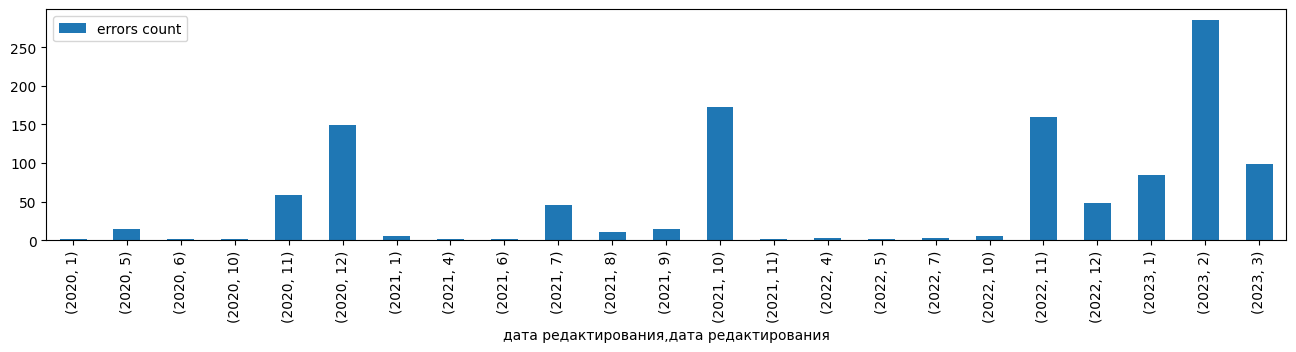

In [13]:
# userdocs.groupby(userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month) [['errors count','дата редактирования']] .count().plot(kind="bar")


# Finding statistical errors

In [ ]:
VALIDATE_STATS=False

In [14]:
# userdocsBak = userdocs.copy()

In [15]:
from collections import Counter

if VALIDATE_STATS:
    # userdocs = validate_markup(user_docs_ids)

    def find_statistical_errors(userdocs):
        l = list(userdocs['vat_unit'].values) + list( userdocs['currency'].values)
        l= [str(k).lower() for k in l]
        c = Counter(l)
        rare_currency=[]
        for k in c:
            if c[k] < 2:
                rare_currency.append(k)


        l = list(userdocs['Псевдоним 1'].values) + list( userdocs['Псевдоним 2'].values)
        l= [str(k).lower() for k in l]
        c = Counter(l)
        rare_aliases=[]
        for k in c:
            if c[k] < 2:
                rare_aliases.append(k)
        # rare_aliases


        l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
        l= [str(k).lower() for k in l]
        c = Counter(l)
        rare_forms=[]
        for k in c:
            if c[k] < 2:
                rare_forms.append(k)
        # print(rare_forms)        



        for i, row in userdocs.iterrows():
            fs1 = str(row['Форма собственности 1']).lower()
            fs2 = str(row['Форма собственности 2']).lower()

            as1 = str(row['Псевдоним 1']).lower()
            as2 = str(row['Псевдоним 2']).lower()


            cs1 = str(row['vat_unit']).lower()
            if cs1 in rare_currency:
                print(i, f'[{cs1=}]')
                add_error(userdocs, i, "Валюта налога очень странная" )

            cs2 = str(row['currency']).lower()
            if cs2 in rare_currency:
                print(i, f'[{cs2=}]')
                add_error(userdocs, i, "Валюта очень странная" )

            if fs1 in rare_forms:
                print(i, f'[{fs1=}]')
                add_error(userdocs, i, "Форма собственности 1 очень странная" )
            if fs2 in rare_forms:
                print(i, f'[{fs2=}]')
                add_error(userdocs, i, "Форма собственности 2 очень странная" )

            if as1 in rare_aliases:
                print(i, f'[{as1=}]')
                add_error(userdocs, i, "Псевдоним 1 очень странный" )
            if as2 in rare_aliases:
                print(i, f'[{as2=}]')
                add_error(userdocs, i, "Псевдоним 2 очень странный" )

    find_statistical_errors(userdocs)            
    userdocs



6152e3798558145da68d8788 [as2='актуарий']
6294ae67df54d406a99b1631 [as1='водопользователь']
6294ae67df54d406a99b1631 [as2='уполномоченный орган']
63908ca4a1bded13e629f2ea [fs2='акционерного общества']
612de89f4f22ff1b7e02fcd7 [cs2='eur']
612de89f4f22ff1b7e02fcd7 [fs1='общество с ограниченной\nответственностью']
63c506c9e2456d59975e1277 [as1='газпромнефть - 123']
63c506c9e2456d59975e1277 [as2='правительство']
62cd56cb32fe0e1ffcc28118 [fs2='company']
6152e26a8558145da68d8771 [fs2='гражданка россии']
5fdb2143542ce403c92b45a1 [fs2='зарегистрированный кандидат в депутаты']
635fa420bf4cb23cbb39282f [as2='жертвополучатель']
63c506e4e2456d59975e1540 [as1='таможенный представитель']
638085766a07f3e980b2c280 [as2='перевозчик']
63ac1fac862ea92bf713c534 [fs2='федеральное бюджетное учреждение']
63c506bbe2456d59975e10d7 [fs2='фонд культурных инициатив']
635fa420bf4cb23cbb39282d [as2='жертвонол уча гель']
63ce49f8e83d1ee490f3f21c [as2='приказодатель']
63ce4b18e83d1ee490f4017c [fs1='автономное учрежде

,дата редактирования,link,error,error missing,errors count,errors severity,subject len,subject kind,Форма собственности 1,Наименование 1,...,Дата,сумма,сумма без налога,currency,сумма (старая),Номер,налог,vat_unit,сумма с налогом,subject
6152e3af8558145da68d8790,2023-02-15 16:29:51.796,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\n,Номер отсутсвует;\nДата отсутсвует;\nНаименова...,7.0,7.0,56.0,Service,NaN,NaN,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3a38558145da68d878d,2023-02-01 14:52:33.786,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,сумма договора отсутсвует;\nНомер отсутсвует;\...,7.0,7.0,77.0,Service,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3798558145da68d8788,2023-02-15 16:30:42.431,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Псевдоним 2 очень странный;\n,сумма договора отсутсвует;\nНомер отсутсвует;\...,8.0,8.0,42.0,Service,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e36c8558145da68d8785,2021-09-30 08:59:33.694,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,сумма договора отсутсвует;\nНомер отсутсвует;\...,7.0,7.0,39.0,Service,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63ce4a56e83d1ee490f3f790,2023-02-28 11:16:25.195,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,,сумма договора отсутсвует;\nНомер отсутсвует;\...,6.0,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fe48220b770574a00555782,2023-02-16 11:40:35.851,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,0.0,74.0,Service,Общество с ограниченной ответственностью,Издательскополиграфическое предприятие «Мастер...,...,«19» февраля 2020,3.1. Стоимость услуг по настоящему договору со...,1520250,рублей,NaN,№ 12/09-2020,304050,рублей,1824300,NaN
5fe48220b770574a00555781,2023-03-01 11:57:57.616,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,,,0.0,0.0,47.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,«30» декабря 2019,3.8. Сумма настоящего Договора составляет 8000...,NaN,рублей,NaN,№ .УПС/20-Н,20,%,8000,NaN
638085806a07f3e980b2c372,2022-11-28 11:21:02.158,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,0.0,45.0,Deal,Физическое лицо,Псковский Завод Мазочных Материалов,...,11 ноября 2021,"Цена Договора составляет 83251,00 (восемьдесят...",NaN,рублей,NaN,№ 343/11/2021,"16650,00",рублей,"99910,00",NaN
5fc63d611d0a1603c7a0c96f,2020-12-18 08:10:11.869,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,0.0,15.0,Loans,Общество с ограниченной ответственностью,Газпромнефть Научно-Технический Центр,...,«20» январь 2020 год.,"592350330,00 (пятьсот девяносто два миллиона т...",NaN,рублей,"592350330,00",12345,NaN,NaN,NaN,NaN


In [16]:
import numpy as np

if VALIDATE_STATS:

    userdocs_subj = userdocs[ ['subject kind', 'Псевдоним 1', 'Псевдоним 2']]
    # userdocs_subj

    def get_alias_pair(v):
        return ' -vs- '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 



    c=Counter([get_alias_pair(v) for i, v in userdocs_subj.iterrows()])
    rare_aliases_pairs=[k for k in c if c[k] < 2]
    for i, row in userdocs.iterrows():
        d=get_alias_pair(row)
        if d in rare_aliases_pairs:
            print(i, f'[{d}]')
            userdocs.at[i, 'strange alias combo'] =f"Необычная пара псевдонимов: {d}"

    print('-'*20)
    del rare_aliases_pairs
    # # rare_aliases_pairs

    # del d

    def get_alias_subject_pair(v, i):
        return ' / '.join(    list([ str(v[f'Псевдоним {i}']).lower(), str(v['subject kind']).lower()])) 

    p1 = [get_alias_subject_pair(v, 1) for i, v in userdocs_subj.iterrows()]


    c=Counter(p1+[get_alias_subject_pair(v, 2) for i, v in userdocs_subj.iterrows()])
    rare_alias_subj_pairs=[k for k in c if c[k] < 3]

    for i, row in userdocs.iterrows():
        d1 = get_alias_subject_pair(row, 1)
        d2 = get_alias_subject_pair(row, 2)

        if d1 in rare_alias_subj_pairs:
            print(i, f'[{d1}]')
            userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d1}"

        if d2 in rare_alias_subj_pairs :
            print(i, f'[{d2}]')
            userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d2}"

    print('-'*20)        
    rare_alias_subj_pairs


6152e3798558145da68d8788 [актуарий -vs- клиент]
6294ae67df54d406a99b1631 [водопользователь -vs- уполномоченный орган]
63908ca4a1bded13e629f2ea [nan -vs- гарант]
612de89f4f22ff1b7e02fcd7 [nan -vs- покупатель]
63c506c9e2456d59975e1277 [газпромнефть - 123 -vs- правительство]
615e9eed8f3b0514f3f42424 [банк -vs- заемщик]
638085ac6a07f3e980b2c726 [nan -vs- партнер]
638085576a07f3e980b2bfef [сторона -vs- сторона]
635fa420bf4cb23cbb39282f [жертвователь -vs- жертвополучатель]
63c506e4e2456d59975e1540 [клиент -vs- таможенный представитель]
638085766a07f3e980b2c280 [клиент -vs- перевозчик]
638085b86a07f3e980b2c860 [компания -vs- оператор]
635fa420bf4cb23cbb39282d [жертвователь -vs- жертвонол уча гель]
63ce49f8e83d1ee490f3f21c [банк -vs- приказодатель]
610d2b0d7dfce422c4272d33 [nan -vs- эмитент]
5fe4821ab770574a00555625 [грузополучатель -vs- поставщик]
5fdb2146542ce403c92b4612 [банк -vs- предприятие]
636cb443f67f84810526f916 [клиент -vs- экспедитор]
6380858a6a07f3e980b2c4aa [заказчик -vs- исполнит

['заказчик / nan',
 'водопользователь / nan',
 'газпромнефть - 123 / deal',
 'сторона-2 / service',
 'покупатель / nan',
 'nan / agencycontract',
 'сторона / service',
 'таможенный представитель / service',
 'предприятие / service',
 'страхователь / nan',
 'ссудополучатель / renting',
 'экспедитор / service',
 'владелец / принципал / agencycontract',
 'потребитель / service',
 'арендатор / nan',
 'ромашка / deal',
 'организатор / service',
 'общество / assettransactions',
 'пользователь / dealintellectualproperty',
 'сублицензиат / deal',
 'потребитель / deal',
 'гпн / service',
 'спонсор / charity',
 'продавец / service',
 'клиент / bankguarantees',
 'поставщик / dealintellectualproperty',
 'подписчик / service',
 'энергоснабжающая организация / service',
 'правообладатель / deal',
 'клиент^ / service',
 'заказии / service',
 'арендодатель / nan',
 'трансгаз / service',
 'подрядчик / deal',
 'плательщик / charity',
 'сторона 2 / service',
 'сторона-1 / dealintellectualproperty',
 'пок

In [17]:
if VALIDATE_STATS:
    _s = f"#### {datetime.today().strftime('%d.%m.%Y')} *Всего* ошибок, недочетов и проч.: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs):0.2f} на документ)"
    display(Markdown(_s))

#### 06.03.2023 *Всего* ошибок, недочетов и проч.: 1969.0 в 1165 документах -- (1.69 на документ)

In [18]:
if VALIDATE_STATS:
    userdocs_subj = userdocs[ ['link','subject kind', 'Псевдоним 1', 'Псевдоним 2', 'strange alias combo', 'strange alias-subject' ]]

    errors_subjects = userdocs_subj[userdocs_subj['strange alias combo'].notnull() | userdocs_subj['strange alias-subject'].notnull() ]
    errors_subjects.to_csv(reports_path / "errors_subjects.csv", index=True)         
    errors_subjects

,link,subject kind,Псевдоним 1,Псевдоним 2,strange alias combo,strange alias-subject
6152e3798558145da68d8788,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Service,Клиент,Актуарий,Необычная пара псевдонимов: актуарий -vs- клиент,Необычная пара псевдоним-предмет: актуарий / s...
63ce4a56e83d1ee490f3f790,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,NaN,Заказчик,Исполнитель,NaN,Необычная пара псевдоним-предмет: исполнитель ...
6294ae67df54d406a99b1631,https://gpn-audit.nemosoft.ru/#/audit/edit/629...,NaN,Водопользователь,Уполномоченный орган,Необычная пара псевдонимов: водопользователь -...,Необычная пара псевдоним-предмет: уполномоченн...
63908ca4a1bded13e629f2ea,https://gpn-audit.nemosoft.ru/#/audit/edit/639...,BankGuarantees,Гарант,NaN,Необычная пара псевдонимов: nan -vs- гарант,Необычная пара псевдоним-предмет: nan / bankgu...
612de89f4f22ff1b7e02fcd7,https://gpn-audit.nemosoft.ru/#/audit/edit/612...,Deal,ПОКУПАТЕЛЬ,NaN,Необычная пара псевдонимов: nan -vs- покупатель,Необычная пара псевдоним-предмет: nan / deal
...,...,...,...,...,...,...
5fe48217b770574a0055559f,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,Deal,Подрядчик,Покупатель,Необычная пара псевдонимов: подрядчик -vs- пок...,Необычная пара псевдоним-предмет: подрядчик / ...
635fa41fbf4cb23cbb39282c,https://gpn-audit.nemosoft.ru/#/audit/edit/635...,Charity,Плательщик,Поставщик,Необычная пара псевдонимов: плательщик -vs- по...,Необычная пара псевдоним-предмет: поставщик / ...
5fc7a034c54bc33809e261a8,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Service,Сторона 2,Сторона 1,NaN,Необычная пара псевдоним-предмет: сторона 1 / ...
638085a86a07f3e980b2c6aa,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,DealIntellectualProperty,Сторона-1,Сторона-2,NaN,Необычная пара псевдоним-предмет: сторона-2 / ...


In [19]:
very_bad_docs = userdocs[userdocs['errors severity']>10]
very_bad_docs

,дата редактирования,link,error,error missing,errors count,errors severity,subject len,subject kind,Форма собственности 1,Наименование 1,...,сумма без налога,currency,сумма (старая),Номер,налог,vat_unit,сумма с налогом,subject,strange alias combo,strange alias-subject
63ce4a56e83d1ee490f3f790,2023-02-28 11:16:25.195,https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,,сумма договора отсутсвует;\nНомер отсутсвует;\...,6.0,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Необычная пара псевдоним-предмет: исполнитель ...
6294ae67df54d406a99b1631,2023-02-06 11:40:45.222,https://gpn-audit.nemosoft.ru/#/audit/edit/629...,Псевдоним 2 очень странный;\nПсевдоним 1 очень...,сумма договора отсутсвует;\nНомер отсутсвует;\...,7.0,16.0,NaN,NaN,Акционерное общество,Газпромнефть-Омский НПЗ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Необычная пара псевдонимов: водопользователь -...,Необычная пара псевдоним-предмет: уполномоченн...
62cd56cb32fe0e1ffcc28118,2023-03-01 09:17:52.771,https://gpn-audit.nemosoft.ru/#/audit/edit/62c...,Форма собственности 2 очень странная;\n,сумма договора отсутсвует;\nДата отсутсвует;\n...,4.0,13.0,NaN,NaN,Акционерное общество,Газпромнефть-Аэро,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Необычная пара псевдоним-предмет: продавец / nan
63908ca3a1bded13e629f2dc,2023-02-11 20:09:39.660,https://gpn-audit.nemosoft.ru/#/audit/edit/639...,валюта не указана;\n,Номер отсутсвует;\nДата отсутсвует;\n,3.0,32.0,121.0,BankGuarantees,Публичное акционерное общество,Сбербанк России,...,NaN,NaN,7000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629dccf80806e3924ebafc70,2023-02-01 14:10:09.624,https://gpn-audit.nemosoft.ru/#/audit/edit/629...,,сумма договора отсутсвует;\nДата отсутсвует;\n...,3.0,12.0,NaN,NaN,Акционерное общество,Газпромнефть-Ноябрьскнефтегаз,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Необычная пара псевдоним-предмет: исполнитель ...
5fb3d7a378df3635f5441d8e,2023-03-06 06:38:10.887,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,валюта налога не указана;\n,Номер отсутсвует;\nДата отсутсвует;\n,3.0,42.0,58.0,Service,Общество с ограниченной ответственностью,Издательско-полиграфическое предприятие «Масте...,...,NaN,рублей,NaN,NaN,"9833,33",NaN,59000,NaN,NaN,NaN
63dccb412c90db0b7a62aa8d,2023-02-03 15:02:44.237,https://gpn-audit.nemosoft.ru/#/audit/edit/63d...,,сумма договора отсутсвует;\nпредмет отсутсвует;\n,2.0,11.0,NaN,NaN,Публичное акционерное общество,Фианит,...,NaN,NaN,NaN,15-01-2021,NaN,NaN,NaN,NaN,NaN,NaN
63dccb422c90db0b7a62aab1,2023-02-03 15:01:21.016,https://gpn-audit.nemosoft.ru/#/audit/edit/63d...,,сумма договора отсутсвует;\nпредмет отсутсвует;\n,2.0,11.0,NaN,NaN,Публичное акционерное общество,Айвенго,...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
635fa420bf4cb23cbb39282d,2023-02-06 12:23:06.492,https://gpn-audit.nemosoft.ru/#/audit/edit/635...,Псевдоним 2 очень странный;\nсумма без налога ...,Дата отсутсвует;\n,3.0,12.0,68.0,Charity,Акционерное общество,Газпромнефть- Омский НПЗ,...,4300 ()()().()(),рублей,NaN,№ OIB-19/030Q0W/£Z /Р/15,NaN,NaN,NaN,NaN,Необычная пара псевдонимов: жертвователь -vs- ...,Необычная пара псевдоним-предмет: жертвонол уч...
5fe4821ab770574a00555634,2023-02-27 09:24:42.244,https://gpn-audit.nemosoft.ru/#/audit/edit/5fe...,"сумма c налогом слишком длинная, должна содерж...",,2.0,12.0,73.0,Service,Общество с ограниченной ответственностью,«Издательско-полиграфическое предприятие «Маст...,...,NaN,рубля,NaN,№ ННГ-19/09000/01759/Р,189884,NaN,составляет ориентировочно 1139304 (один миллио...,NaN,NaN,NaN


# Save reports

In [20]:
# yseterday_userdocs = validate_markup(yseterday_ids)

# yseterday_userdocs['errors severity'] = yseterday_userdocs['errors severity'].astype('int')
# yseterday_userdocs['errors count'] = yseterday_userdocs['errors count'].astype('int')


userdocs['errors severity'] = userdocs['errors severity'].astype('int')
userdocs['errors count'] = userdocs['errors count'].astype('int')

In [21]:
if 'errors_report_metric_prefix' in globals():
    errors_report_metric_prefix = globals()['errors_report_metric_prefix']
else:
    errors_report_metric_prefix = "user"
 
userdocs=userdocs.sort_values(["errors severity", "errors count", "дата редактирования"], ascending=False)
userdocs.to_csv(reports_fn, index=True)    
# userdocs

mlflow.log_metric(f'severity', userdocs['errors severity'].sum())
mlflow.log_metric(f'severity per doc', userdocs['errors severity'].sum()/len(userdocs))

mlflow.log_metric(f'errors', userdocs['errors count'].sum())
mlflow.log_metric(f'errors per doc', userdocs['errors count'].sum()/len(userdocs))

mlflow.log_metric(f'docs count',  len(userdocs))
mlflow.log_metric(f'severe docs',  len(very_bad_docs))
mlflow.log_param('subset code',  str(errors_report_metric_prefix))
mlflow.log_artifact(reports_fn)

 


# End mlflow logging

In [22]:

print(active_mlflow_run.info)
mlflow.end_run()

<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/492e101d3eaa4258b708a873740e6cfd/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='492e101d3eaa4258b708a873740e6cfd', run_name='orderly-bee-454', run_uuid='492e101d3eaa4258b708a873740e6cfd', start_time=1678101809404, status='RUNNING', user_id='root'>
